<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/Bitcoin_Price_and_its_Movement_Direction_Prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

# **Packages**

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [4]:
df = pd.read_csv("/content/bitcoin.csv")

Modify Timestamp

In [5]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')

Spot the missing values

In [6]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [9]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [10]:
df = df.dropna()

# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [11]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

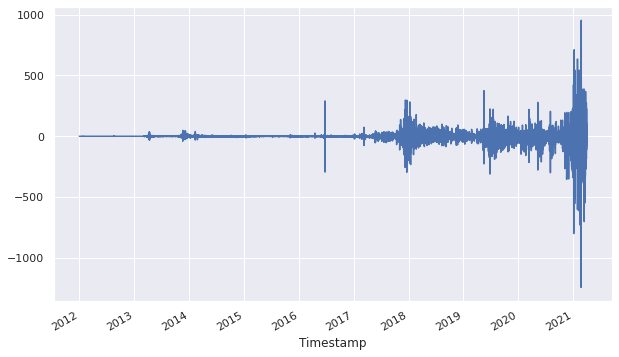

In [12]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [13]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

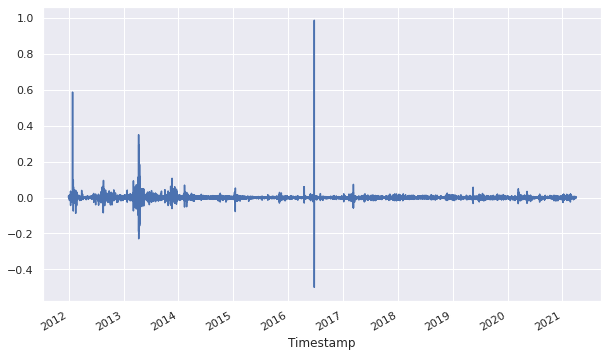

In [14]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [15]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:53:00,4.390,4.390,4.39,4.39,0.555046,2.436653,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:54:00,4.390,4.390,4.39,4.39,0.654511,2.873305,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:55:00,4.390,4.390,4.39,4.39,0.753977,3.309958,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:56:00,4.390,4.390,4.39,4.39,0.853442,3.746611,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:57:00,4.390,4.390,4.39,4.39,0.952907,4.183264,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:51:00,58677.050,58699.900,58660.00,58699.90,2.672676,156832.692130,58680.021260,58684.2125,2.8925,Up,0.000049,0.000234,0.000234,0.000545,-0.000263,-0.000478
2021-03-30 23:52:00,58697.865,58715.565,58679.17,58699.20,1.440329,84520.873706,58691.157958,58697.9500,13.7375,Up,0.000234,0.000234,0.000545,-0.000263,-0.000478,-0.000228
2021-03-30 23:53:00,58718.680,58731.230,58698.34,58698.50,0.207983,12209.055282,58702.294657,58711.6875,13.7375,Up,0.000234,0.000545,-0.000263,-0.000478,-0.000228,0.000372


Cleaned Dataset Display

In [16]:
df.shape

(4857377, 16)

In [17]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0


#**Exploratory Data Analysis**

Zheming's Part

Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

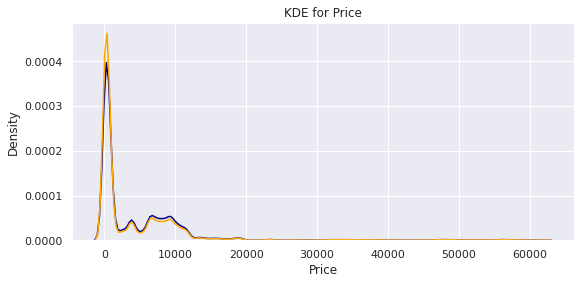

In [14]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

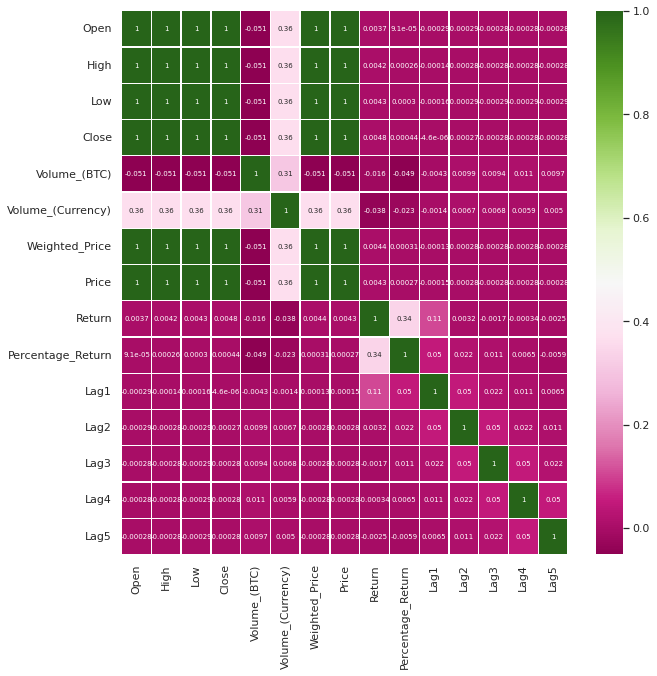

In [15]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [16]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


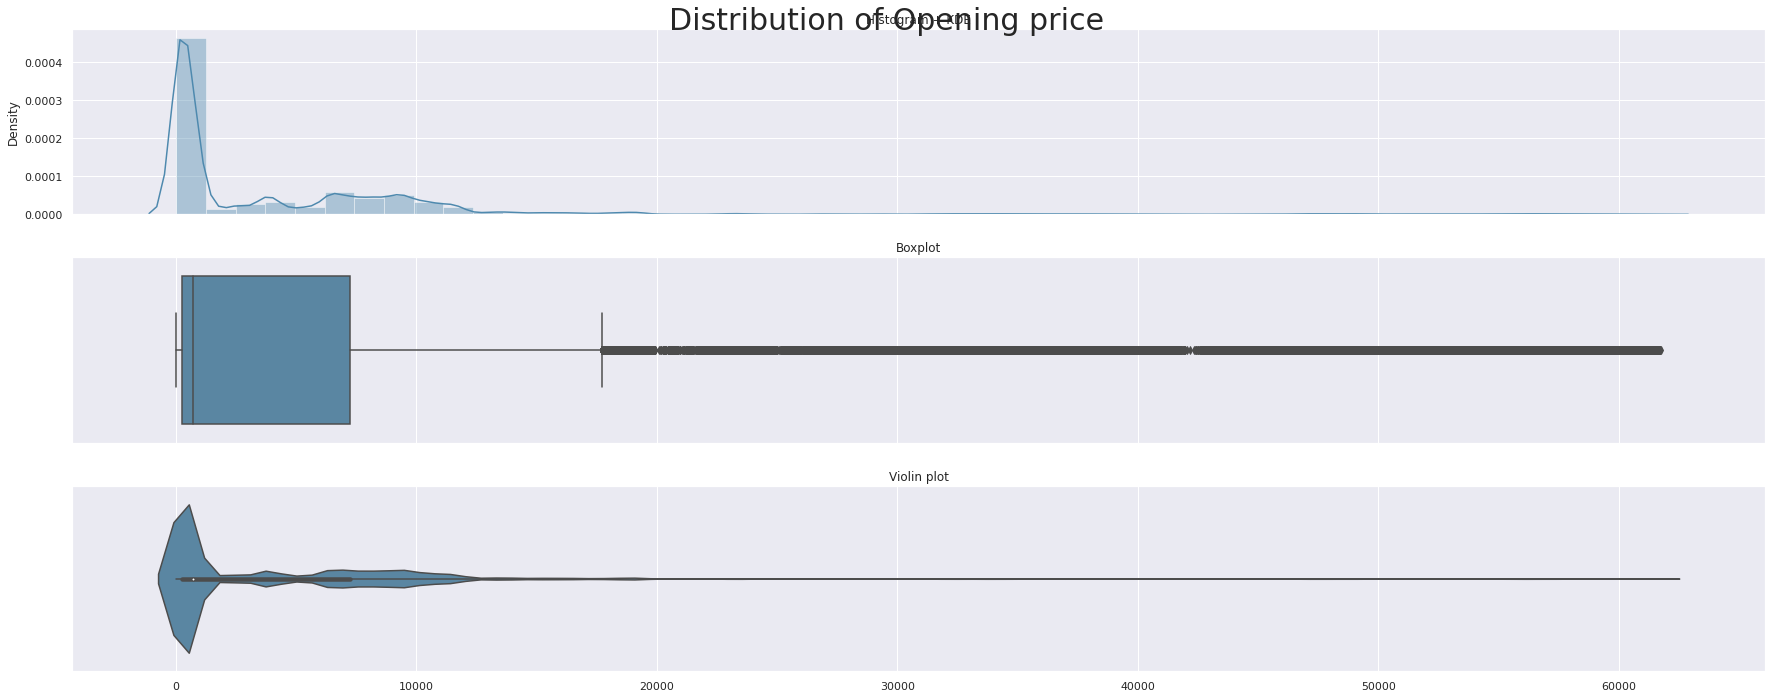

In [17]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

# **ARIMA Model**

Geech's part here

In [18]:
df = df.resample("24H").mean()

In [19]:
df.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,
2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,4.477681,0.000196,4.387418e-05,4.382886e-05,0.000044,0.000044,0.000044,0.000044
2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.765576,0.000292,6.093222e-05,6.093222e-05,0.000061,0.000061,0.000061,0.000061
2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,5.006549,0.000055,1.101191e-05,1.105840e-05,0.000011,0.000011,0.000011,0.000011
2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,5.206530,-0.000005,-8.537691e-07,-9.760750e-07,-0.000001,-0.000001,-0.000001,-0.000001
2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,5.222105,0.000412,7.683091e-05,7.697206e-05,0.000077,0.000077,0.000077,0.000078


In [20]:
df.shape

(3379, 15)

In [21]:
df= df[["Close"]].copy()

In [22]:
df.describe()

,Close
count,3376.000000
mean,4605.639551
std,8207.350418
min,4.360638
25%,245.230391
50%,697.703091
75%,7242.406733
max,60460.509722


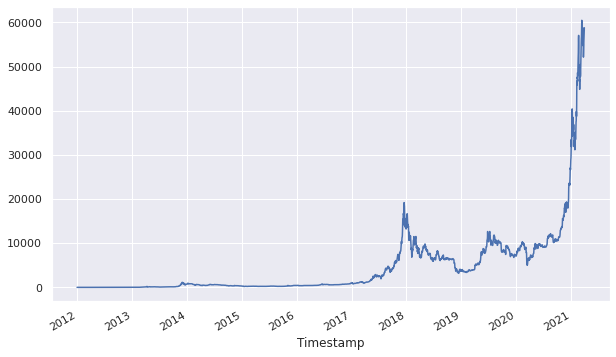

In [44]:
df.Close.dropna().plot()

In [24]:
from numpy import log

In [25]:
#split the time series into two group 
#calculate the mean and variance of each group of numbers
#compare the values. 
#mean and variance look very different = non-stationary time series
#cannot reject null 
X = df.Close
X=log(X)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=4.833398, mean2=8.641288
variance1=2.801974, variance2=1.048945


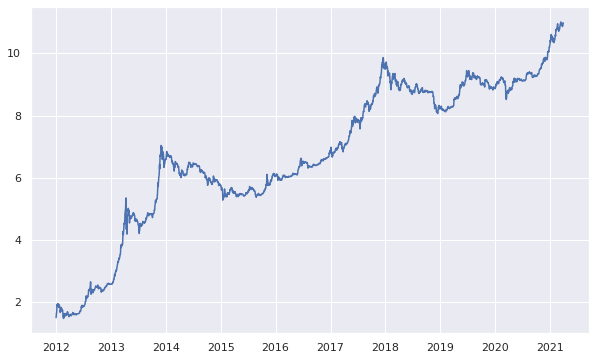

In [53]:
plt.plot(X)
plt.show()

In [27]:
#Find out if the time series is stationary
#ADF test check if the price is stationary
#null hypothesis of ADF is that the time series is not stationary 
# if P-value < 0.05 then reject null 
from statsmodels.tsa.stattools import adfuller

In [31]:
# d=0 if the time series is stationary 
test_adf = adfuller(df.Close.dropna())

print(f" ADF Statistics: {test_adf[0]}")
print(f" P-value: {test_adf[1]}")

 ADF Statistics: 6.1895129620459315
 P-value: 1.0


In [32]:
#Autocorrelation Function (ACF)
from statsmodels.graphics.tsaplots import plot_acf

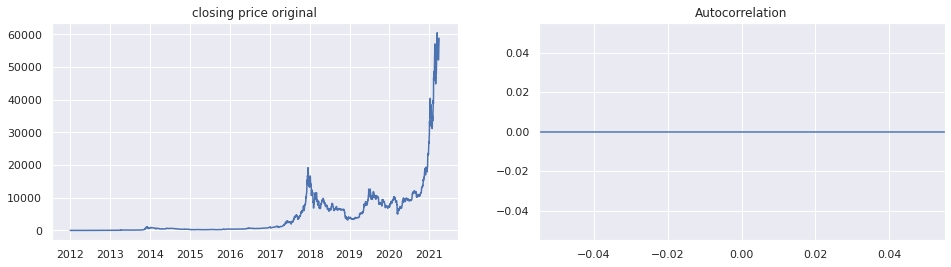

In [45]:
#finding d- order of differencing 
fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(df.Close)
ax1.set_title('closing price original')
plot_acf(df.Close, ax= ax2);

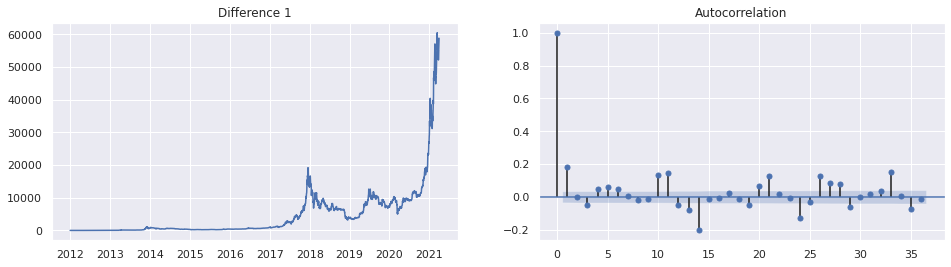

In [46]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(df.Close)
ax1.set_title('Difference 1')
plot_acf(diff, ax= ax2);

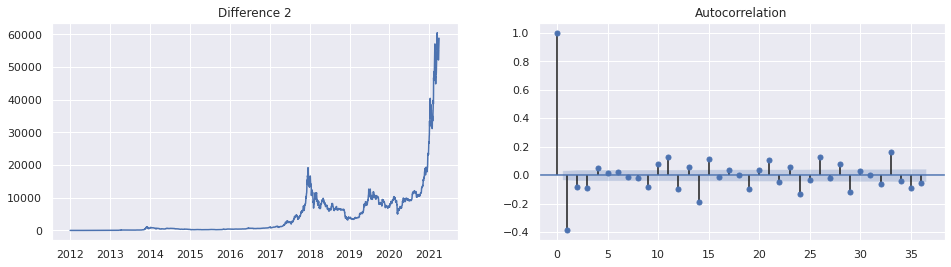

In [47]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(df.Close)
ax1.set_title('Difference 2')
plot_acf(diff, ax= ax2);

In [56]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 25.3 MB/s 
     |████████████████████████████████| 9.5 MB 51.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [36]:
from pmdarima.arima.utils import ndiffs

In [38]:
ndiffs(df.Close.dropna(), test="adf") #deciding d for order of differencing 

1

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf

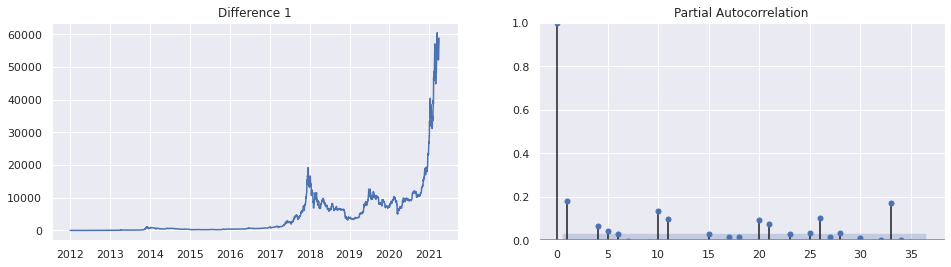

In [40]:
# Finding P- the order of Auto regressive term in the ARIMA model. It refers to the numbers of lags to be used as predictors. 
# Inspecting the partial autocorrelation plot (PACF)
diff = df.Close.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(df.Close)
ax1.set_title('Difference 1')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax= ax2);

Finding q is the order of the moving average (MA)term. 
the number of lagged forecast errors that should go into the ARIMA model
use ACF plot to find q 

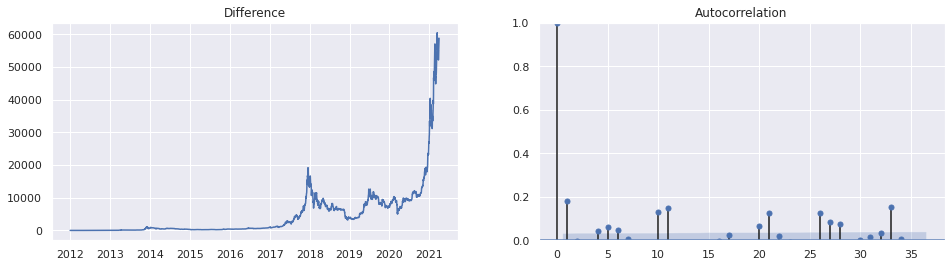

In [75]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(df.Close)
ax1.set_title('Difference')
ax2.set_ylim(0, 1)
plot_acf(diff, ax= ax2);

In [62]:
from statsmodels.tsa.arima_model import ARIMA

In [76]:
#fitting the arima model 
# ARIMA model 
ari_model = ARIMA(df.Close.dropna(), order=(1,1,1))
result= ari_model.fit(disp= False) # disp is False 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

In [77]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3375
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -24686.547
Method:                       css-mle   S.D. of innovations            363.431
Date:                Sat, 25 Sep 2021   AIC                          49381.093
Time:                        05:22:19   BIC                          49405.590
Sample:                             1   HQIC                         49389.852
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            17.4146      7.496      2.323      0.020       2.723      32.106
ar.L1.D.Close     0.0645      0.072      0.896      0.370      -0.077       0.206
ma.L1.D.Close     0.1210      0.071     

In [85]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

In [ ]:
#plot residuals 
# res = pd.DataFrame(test_adf.resid)
res = sms.omni_normtest(test_adf.resid)
fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(res)
ax2.hist(res, density= True);

In [ ]:
#Actual vs. Fitted 
test_adf.plot_predict(start= 1, end= 60, dynamic= False);

In [95]:
# Split train set 
n= int(len(df)*0.8)
train_set = df.Close.dropna()[:n]
test_set = df.Close.dropna()[n:]

In [96]:
print(len(train_set))
print(len(test_set))

2703
673


In [97]:
model= ARIMA(train_set, order= (1,1,1))
result_train = model.fit(disp= False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

In [98]:
result_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2702
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17688.532
Method:                       css-mle   S.D. of innovations            168.597
Date:                Sat, 25 Sep 2021   AIC                          35385.064
Time:                        05:31:13   BIC                          35408.671
Sample:                             1   HQIC                         35393.601
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.2278      4.107      0.786      0.432      -4.822      11.277
ar.L1.D.Close     0.2904      0.079      3.672      0.000       0.135       0.445
ma.L1.D.Close    -0.1014      0.082     -1.244      0.214      -0.261       0.058
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.4431           +0.0000j            3.4431            0.0000
MA.1            9.8592           +0.0000j            9.8592            0.0000
-----------------------------------------------------------------------------
"""

In [100]:
#forecast 30 steps 
steps =30 
fc, se, conf = result.forecast(steps)

In [101]:
# out of sample forecast
fc

array([58842.95932232, 58863.42944171, 58881.04119369, 58898.46855363,
       58915.88401852, 58933.29871607, 58950.71336411, 58968.12800896,
       58985.54265361, 59002.95729824, 59020.37194287, 59037.7865875 ,
       59055.20123213, 59072.61587677, 59090.0305214 , 59107.44516603,
       59124.85981066, 59142.27445529, 59159.68909992, 59177.10374455,
       59194.51838918, 59211.93303381, 59229.34767844, 59246.76232307,
       59264.17696771, 59281.59161234, 59299.00625697, 59316.4209016 ,
       59333.83554623, 59351.25019086])

In [102]:
# standard error of the forecast 
se

array([ 363.43070934,  563.65737893,  712.11215036,  834.71075863,
        941.48613856, 1037.32890854, 1125.03619741, 1206.38369962,
       1282.58208946, 1354.50064663, 1422.78852513, 1487.94568877,
       1550.36691085, 1610.37037472, 1668.21699107, 1724.12386875,
       1778.27396661, 1830.82317164, 1881.90559576, 1931.63761013,
       1980.1209666 , 2027.44524658, 2073.68980645, 2118.92534057,
       2163.21514982, 2206.61618093, 2249.17988508, 2290.95293294,
       2331.97781432, 2372.29334442])

In [103]:
#upper bound and lower bound confidence level 
conf

array([[58130.64822115, 59555.27042349],
       [57758.6812794 , 59968.17760403],
       [57485.32702604, 60276.75536135],
       [57262.46552921, 60534.47157806],
       [57070.605095  , 60761.16294205],
       [56900.1714152 , 60966.42601693],
       [56745.68293588, 61155.74379235],
       [56603.65940617, 61332.59661176],
       [56471.72795105, 61499.35735617],
       [56348.18481381, 61657.72978267],
       [56231.75767601, 61808.98620974],
       [56121.46662655, 61954.10654845],
       [56016.53792405, 62093.86454022],
       [55916.34794055, 62228.88381298],
       [55820.38530051, 62359.67574228],
       [55728.22447839, 62486.66585367],
       [55639.50688146, 62610.21273985],
       [55553.92697681, 62730.62193377],
       [55471.22190993, 62848.15628991],
       [55391.16359752, 62963.04389158],
       [55313.55260962, 63075.48416875],
       [55238.21336989, 63185.65269774],
       [55164.99034269, 63293.7050142 ],
       [55093.74496963, 63399.77967652],
       [55024.35

In [ ]:
fc = pd.Series(fc, index= train_set[:step].index)
lower = pd.Series(conf[:, 0]), index= train_set[:step].index)
upper = pd.Series(conf[:, 1]), index= train_set[:step].index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(train_set[:steps], label= "actual")
plt.plot(fc, label= "forecast")
plt.fill_between(lower.index, lower, upper, color= "k", alpha= 0.1)
plt.title("Forecast Vs Actual")
plt.legend(loc= "Upper Left")

# **Simple RNN**

Yihan Jia's part here

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm

2. How to Create an ARIMA Model for Time Series Forecasting in Python. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

3. How to Grid Search ARIMA Model Hyperparameters with Python. https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/